## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

Batch loss filter after https://github.com/oguiza/fastai_extensions/blob/master/03_BatchLossFilter.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

from fastai_extensions import *

In [3]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [4]:
data_dir = Path('data')

In [5]:
MODEL_NAME='batch_loss'

In [6]:
NB_NUM='11_3'

In [7]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 10e3220e, DATE: 20191223


In [8]:
#DATE = '20191130'
#UID = 'a3967fe9'

In [9]:
SUB_NUM='30'

In [10]:
img_size=256
bs=64

In [11]:
train_images=data_dir/f'train/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{img_size}'

In [12]:
test_names = get_image_files(test_images)

In [13]:
assert len(test_names)==7325

### using valid + gold preds instead of all

In [14]:
df_gold=pd.read_csv(data_dir/'df_all_repl_st_lucia_castries_gold_concrete_cement.csv')

In [15]:
df_gold.drop(columns=['target'],inplace=True)

In [16]:
df_gold=df_gold[['id','roof_material','verified','country','region']]

In [17]:
df_gold.tail()

,id,roof_material,verified,country,region
22534,7a3585be,concrete_cement,True,st_lucia,castries
22535,7a1d3324,concrete_cement,True,st_lucia,castries
22536,7a30849c,concrete_cement,True,st_lucia,castries
22537,7a27186c,concrete_cement,True,st_lucia,castries
22538,7a34ef78,concrete_cement,True,st_lucia,castries


In [18]:
df_pewter_70pct=pd.read_csv(data_dir/'st_lucia_castries_gros_islet_70pct_rn50-rn152-dn121_preds.csv')

In [19]:
df_pewter_70pct.tail()

,id,roof_material,verified,country,region
3364,7a3a5eea,other,True,st_lucia,gros_islet
3365,7a3b3dce,other,True,st_lucia,castries
3366,7a3cfda8,other,True,st_lucia,gros_islet
3367,7a42d1a6,other,True,st_lucia,gros_islet
3368,7a4494c8,other,True,st_lucia,gros_islet


In [20]:
frames = [df_gold, df_pewter_70pct]

df_gold_pewter = pd.concat(frames)

In [21]:
#### test data

In [22]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [23]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [24]:
assert len(df_test)==7325

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [25]:
tfms = get_transforms(flip_vert=True, max_lighting=0.2, max_zoom=1.2, max_warp=0.)

### setup dataset

In [26]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_gold_pewter, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [27]:
data = (src.transform(tfms, size=img_size)
        .databunch(bs=bs).normalize(imagenet_stats))

In [28]:
#to check what params object has
#dir(data)

In [29]:
data.label_list

LabelLists;

Train: LabelList (20727 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (5181 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,healthy_metal,healthy_metal,irregular_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256

In [30]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

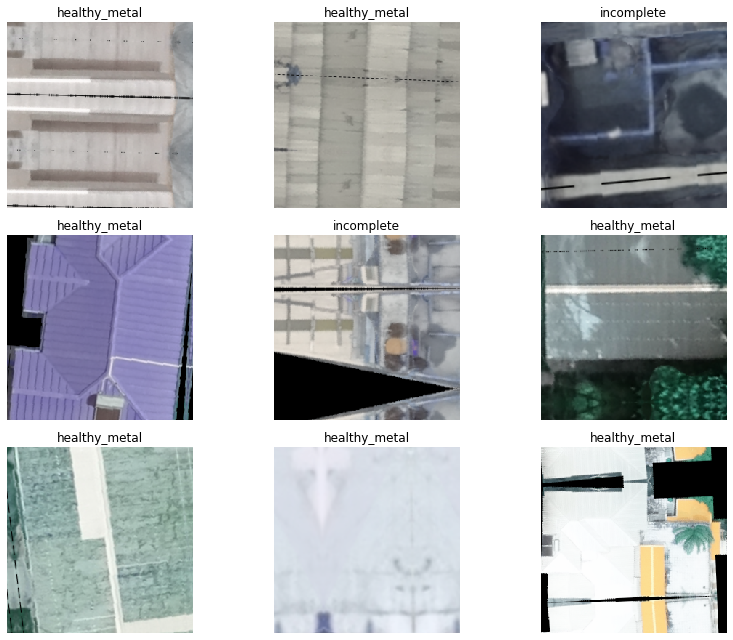

In [31]:
data.show_batch(rows=3, figsize=(12,9))

In [32]:
import math

class BatchLossFilterCallback(LearnerCallback):
    _order = -20

    def __init__(self, learn:Learner, min_sample_perc:float=0., min_loss_perc:float=0.):
        super().__init__(learn)
        assert min_sample_perc >0. or min_loss_perc > 0., 'min_sample_perc <= 0 and min_loss_perc <= 0'
        self.min_sample_perc, self.min_loss_perc = min_sample_perc, min_loss_perc
        self.learn = learn
        self.model = learn.model
        self.crit = learn.loss_func
        if hasattr(self.crit, 'reduction'):  self.red = self.crit.reduction
        self.sel_losses_sum, self.losses_sum = 0., 0.
        self.sel_samples, self.samples = 0., 0.
        self.recorder.add_metric_names(["loss_perc", "samp_perc"])

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.sel_losses_sum, self.losses_sum = 0., 0.
        self.sel_samples, self.samples = 0., 0.
    
    def on_batch_begin(self, last_input, last_target, train, epoch, **kwargs):
        if not train or epoch == 0: return
        if hasattr(self.crit, 'reduction'):  setattr(self.crit, 'reduction', 'none')
        with torch.no_grad():  
            self.losses = np.array(self.crit(self.model(last_input).cpu(), last_target.cpu()))
        if hasattr(self.crit, 'reduction'):  setattr(self.crit, 'reduction', self.red)
        self.get_loss_idxs()
        self.sel_losses_sum += self.losses[self.idxs].sum()
        self.losses_sum += self.losses.sum()
        self.sel_samples += len(self.idxs)
        self.samples += len(self.losses)
        return {"last_input": last_input[self.idxs], "last_target": last_target[self.idxs]}
        
    def on_epoch_end(self, epoch, last_metrics, **kwargs):
        loss_perc = self.sel_losses_sum / self.losses_sum if epoch > 0 else 1.
        sample_perc = self.sel_samples / self.samples if epoch > 0 else 1.
        return add_metrics(last_metrics, [loss_perc, sample_perc])
    
    def on_train_end(self, **kwargs):
        """At the end of training this calleback will be removed"""
        if hasattr(self.learn.loss_func, 'reduction'):  setattr(self.learn.loss_func, 'reduction', self.red)
        drop_cb_fn(self.learn, 'TopLossesCallback')
        
    def get_loss_idxs(self):
        idxs = np.argsort(self.losses)[::-1]
        sample_max = math.ceil(len(idxs) * self.min_sample_perc)
        self.losses /= self.losses.sum()
        loss_max = np.argmax(self.losses[idxs].cumsum() >= self.min_loss_perc) + 1
        self.idxs =  list(idxs[:max(sample_max, loss_max)])
        

def batch_loss_filter(learn:Learner, min_sample_perc:float=0., min_loss_perc:float=.9)->Learner:
    learn.callback_fns.append(partial(BatchLossFilterCallback, min_sample_perc=min_sample_perc, 
                                      min_loss_perc=min_loss_perc))
    return learn

Learner.batch_loss_filter = batch_loss_filter

### Model

In [33]:
arch = models.resnet50
arch_name = 'rn50'

In [34]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True)

In [35]:
learn = learn.batch_loss_filter(min_loss_perc=.9)

We use the LR Finder to pick a good learning rate.

### (Re)train model

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


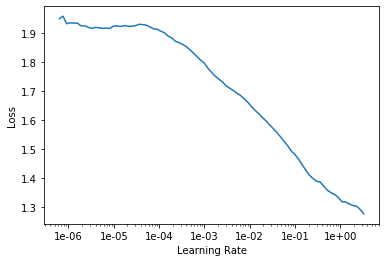

In [37]:
learn.recorder.plot()

Then we can fit the head of our network.

In [38]:
lr = 1e-2

In [39]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,loss_perc,samp_perc,time
0,0.697645,0.555154,0.158078,1.000000,1.000000,01:28
1,0.717150,0.418376,0.136846,0.903070,0.606908,02:00
2,0.684075,0.398888,0.128161,0.903191,0.580447,01:40
3,0.644678,0.356922,0.117931,0.903061,0.574158,01:40
4,0.611627,0.363793,0.121598,0.903159,0.574545,01:41


<pre>
03_1 results

epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.508273 	1.170024 	0.339911 	01:16
1 	0.471699 	0.494651 	0.166297 	01:22
2 	0.439157 	0.417086 	0.152328 	01:23
3 	0.402381 	0.370002 	0.127938 	01:23
4 	0.355355 	0.360440 	0.126608 	01:22
    </pre>

In [40]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')


#### Load model

In [41]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (20727 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (5181 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,healthy_metal,healthy_metal,irregular_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('healthy_metal', 'irregular_metal', 233),
 ('irregular_metal', 'healthy_metal', 152),
 ('incomplete', 'irregular_metal', 71),
 ('other', 'healthy_metal', 39),
 ('concrete_cement', 'healthy_metal', 33),
 ('healthy_metal', 'concrete_cement', 18),
 ('other', 'irregular_metal', 16),
 ('concrete_cement', 'incomplete', 15),
 ('concrete_cement', 'irregular_metal', 14),
 ('irregular_metal', 'incomplete', 12),
 ('incomplete', 'concrete_cement', 9),
 ('incomplete', 'healthy_metal', 8),
 ('irregular_metal', 'concrete_cement', 6),
 ('healthy_metal', 'incomplete', 3)]

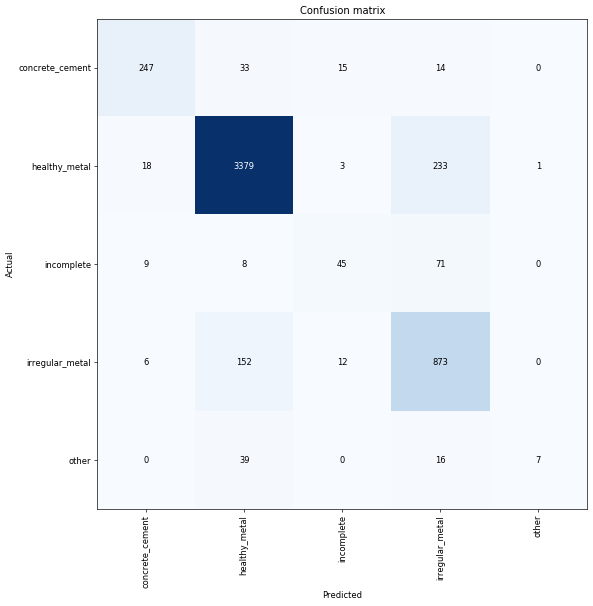

In [43]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [44]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


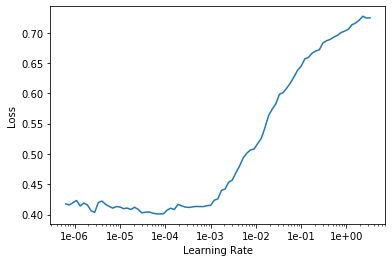

In [45]:
learn.lr_find()
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,loss_perc,samp_perc,time
0,0.389997,0.368290,0.122949,1.000000,1.000000,01:58
1,0.684533,0.359078,0.118510,0.903179,0.556598,01:55
2,0.635627,0.350251,0.112913,0.903153,0.574497,01:43
3,0.570079,0.330696,0.111368,0.903177,0.575174,01:44
4,0.555508,0.318426,0.107701,0.902900,0.569466,01:43


In [47]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [48]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (20727 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (5181 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,healthy_metal,healthy_metal,irregular_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4

In [49]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,loss_perc,samp_perc,time
0,0.331408,0.334915,0.112141,1.000000,1.000000,01:51
1,0.637159,0.351911,0.115422,0.903222,0.537587,01:43
2,0.584578,0.328113,0.115615,0.903364,0.554276,01:42
3,0.509386,0.332774,0.116387,0.903163,0.557904,01:42
4,0.515724,0.319593,0.109438,0.902938,0.558195,01:45


<pre>
03_1

 epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.344736 	0.349004 	0.125277 	01:27
1 	0.343708 	0.355190 	0.129047 	01:15
2 	0.351904 	0.371296 	0.131042 	01:14
3 	0.346994 	0.346989 	0.123947 	01:14
4 	0.323809 	0.346372 	0.126608 	01:15
</pre>

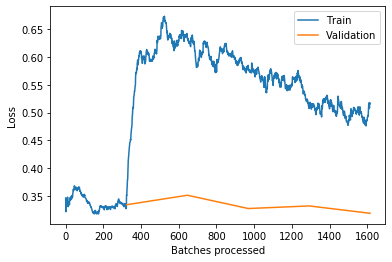

In [50]:
learn.recorder.plot_losses()

In [51]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [52]:
learn=learn.to_fp32()

In [53]:
learn.export(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

### inference

In [54]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [55]:
len(test_dataset)

15325

In [56]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [57]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [58]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [59]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [60]:
len(learn.dl(DatasetType.Test))

240

Get number of items in the Valid dataset (in DeviceDataLoader)

In [61]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [62]:
labels = np.argmax(preds, 1)

In [63]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [64]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [65]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [66]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [67]:
test_predictions[0]

'healthy_metal'

In [68]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [69]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a468774.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4b7946.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4e81f4.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a501f50.tif')], dtype=object)

In [70]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [71]:
preds_list[0]

[0.07809674739837646,
 0.9014826416969299,
 0.0038149941246956587,
 0.013513987883925438,
 0.0030916661489754915]

In [72]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [73]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [74]:
pred_df.insert(loc=0, column='id', value=ids)

In [75]:
pred_df.columns = cols

In [76]:
pred_ids=pred_df['id'].values.tolist()

In [77]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [78]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [79]:
baseline_ids=df_baseline['id'].values.tolist()

In [80]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [81]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [82]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.078097,0.901483,0.003815,0.013514,0.003092,7a4d9168
1,7a4ae922,0.010379,0.872070,0.004483,0.110996,0.002073,7a4ae922
2,7a48ca98,0.008313,0.145829,0.046209,0.798159,0.001489,7a48ca98
3,7a49c614,0.006366,0.676988,0.007973,0.305927,0.002746,7a49c614
4,7a4dd4f2,0.002865,0.744879,0.002915,0.243088,0.006252,7a4dd4f2


In [83]:
pred_df=pred_df.sort_values('id_cat')

In [84]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
8041,7a4d630a,0.011814,0.946574,0.004827,0.027956,0.008829,7a4d630a
716,7a4d630a,0.011814,0.946574,0.004827,0.027956,0.008829,7a4d630a
764,7a4bbbd6,0.002290,0.951689,0.001712,0.041518,0.002791,7a4bbbd6
8089,7a4bbbd6,0.002290,0.951689,0.001712,0.041518,0.002791,7a4bbbd6
1841,7a4ac744,0.013206,0.611002,0.008648,0.365273,0.001871,7a4ac744


In [85]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [86]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
8041,7a4d630a,0.011814,0.946574,0.004827,0.027956,0.008829
716,7a4d630a,0.011814,0.946574,0.004827,0.027956,0.008829
764,7a4bbbd6,0.002290,0.951689,0.001712,0.041518,0.002791
8089,7a4bbbd6,0.002290,0.951689,0.001712,0.041518,0.002791
1841,7a4ac744,0.013206,0.611002,0.008648,0.365273,0.001871


In [87]:
pred_df=pred_df.drop_duplicates(subset=['id'])

In [88]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

### Submission 35: 0.4642


In [89]:
arch_name = 'rn50'
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

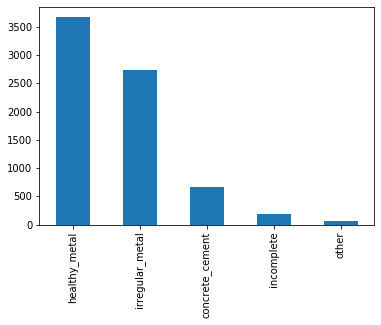

In [90]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")

In [92]:
print(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

stage-2-rn50-11_3-batch_loss-20191223-10e3220e.csv
